# 🔊 Speech Emotion Recognition –   (RAVDESS)


In [25]:
import warnings
warnings.filterwarnings('ignore')  

import cv2
from transformers import pipeline
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder



from termcolor import cprint  

import librosa
import librosa.display

from tqdm import tqdm


%matplotlib inline
sns.set(style="whitegrid")

print("✅ All packages imported successfully!")


✅ All packages imported successfully!


```bash
cd ai-internship-project                     # Go to your repo
git add Datasets/RAVDESS                    # Stage the RAVDESS folder
git commit -m "Add RAVDESS dataset"         # Commit the change
git push origin main                        # Push to GitHub
```

# Define Label Mapping and Load Info

In [2]:
# Your dataset path
ravdess_path = '/teamspace/studios/this_studio/ai-internship-project/Datasets/RAVDESS'

# Emotion code to label mapping
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# Function to list all audio files with their emotion labels
def get_ravdess_audio_list(path):
    audio_data = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.wav'):
                parts = file.split('-')
                if len(parts) >= 3:
                    emotion_code = parts[2]
                    emotion_label = emotion_map.get(emotion_code)
                    if emotion_label:
                        full_path = os.path.join(root, file)
                        audio_data.append((full_path, emotion_label))
    return pd.DataFrame(audio_data, columns=['path', 'emotion'])

In [3]:
# Load the dataset metadata
df = get_ravdess_audio_list(ravdess_path)
df.head()

,path,emotion
0,/teamspace/studios/this_studio/ai-internship-p...,neutral
1,/teamspace/studios/this_studio/ai-internship-p...,neutral
2,/teamspace/studios/this_studio/ai-internship-p...,neutral
3,/teamspace/studios/this_studio/ai-internship-p...,neutral
4,/teamspace/studios/this_studio/ai-internship-p...,calm


In [4]:
print(f"Total samples: {len(df)}")


Total samples: 2880


In [5]:
emotion_counts = df['emotion'].value_counts()
print("Emotion distribution:")
print(emotion_counts)

Emotion distribution:
emotion
calm         384
happy        384
sad          384
angry        384
fearful      384
disgust      384
surprised    384
neutral      192
Name: count, dtype: int64


# Plot Class Distribution

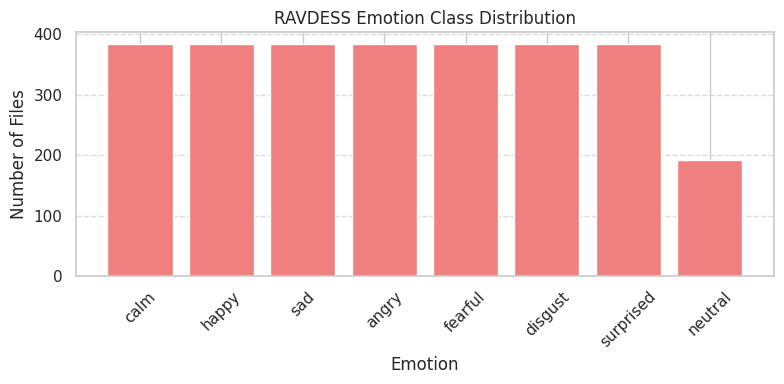

In [6]:
plt.figure(figsize=(8, 4))
plt.bar(emotion_counts.index, emotion_counts.values, color='lightcoral')
plt.title("RAVDESS Emotion Class Distribution")
plt.xlabel("Emotion")
plt.ylabel("Number of Files")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

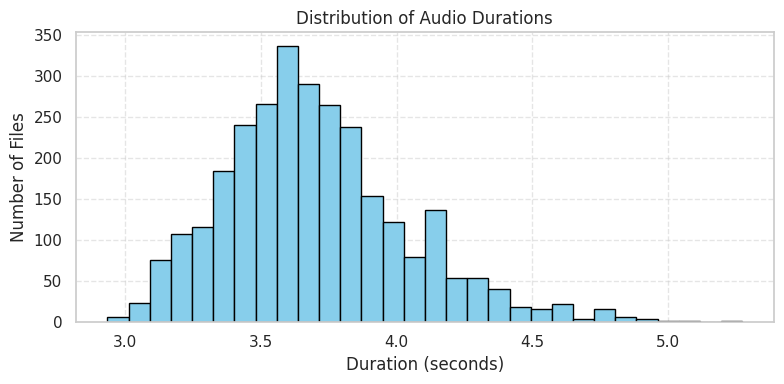

In [7]:
def get_duration(file_path):
    try:
        y, sr = librosa.load(file_path)
        return librosa.get_duration(y=y, sr=sr)
    except:
        return None

df['duration'] = df['path'].apply(get_duration)

# Plot distribution
plt.figure(figsize=(8, 4))
plt.hist(df['duration'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Audio Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Number of Files")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Visualize Waveform and Spectrogram

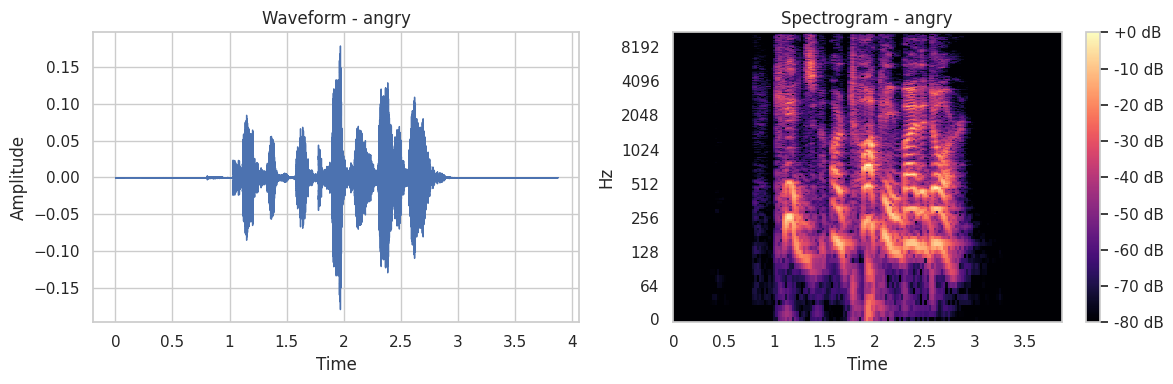

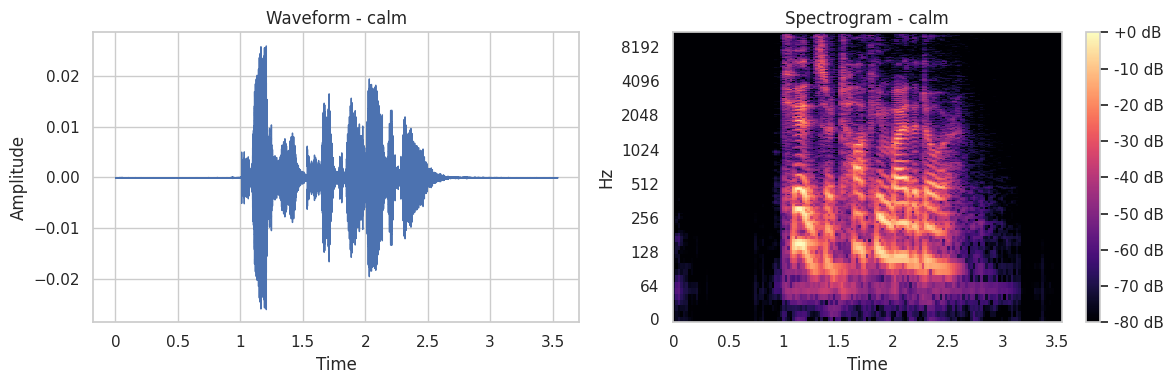

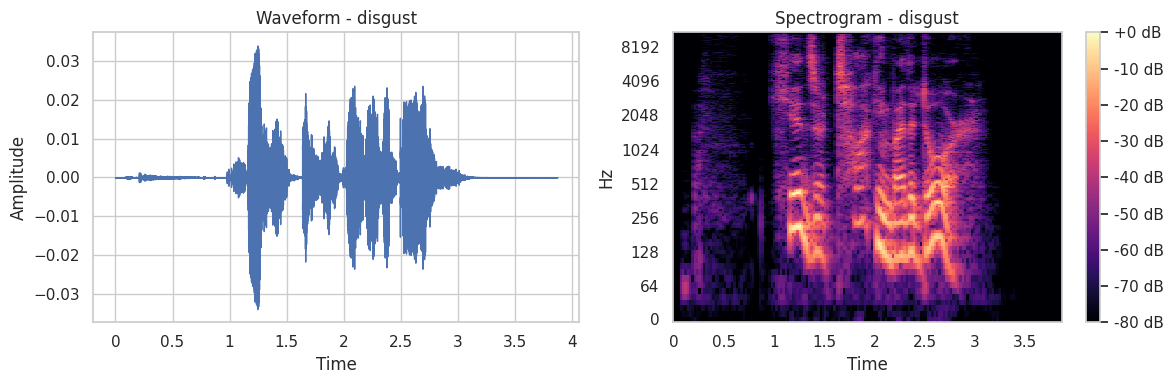

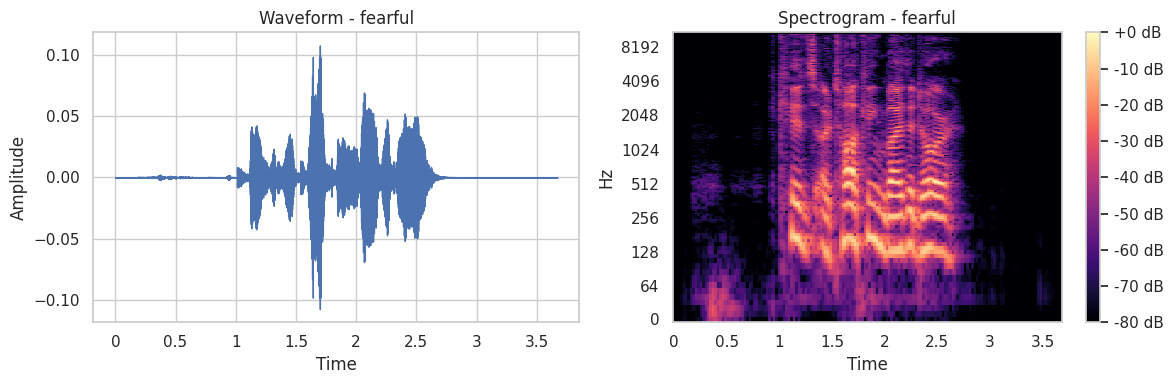

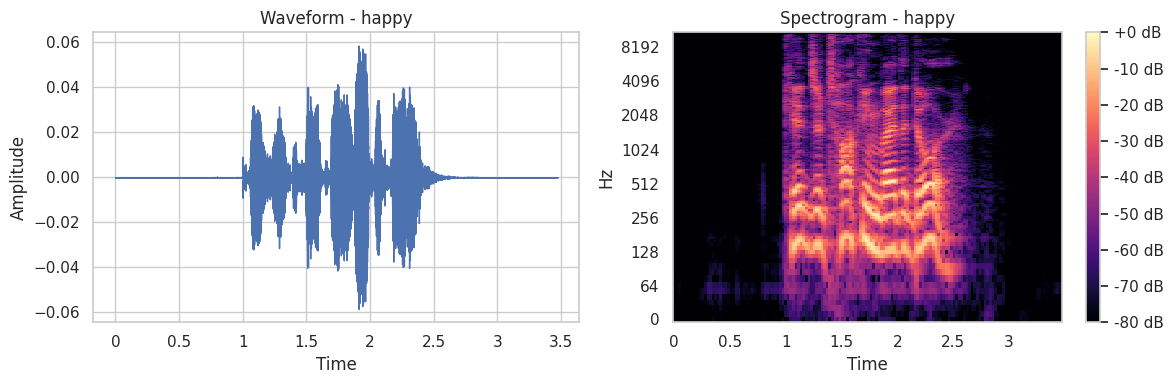

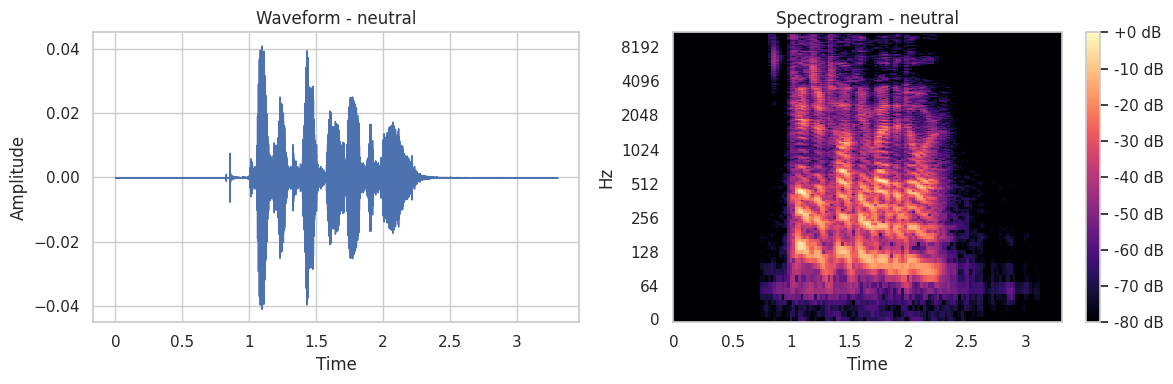

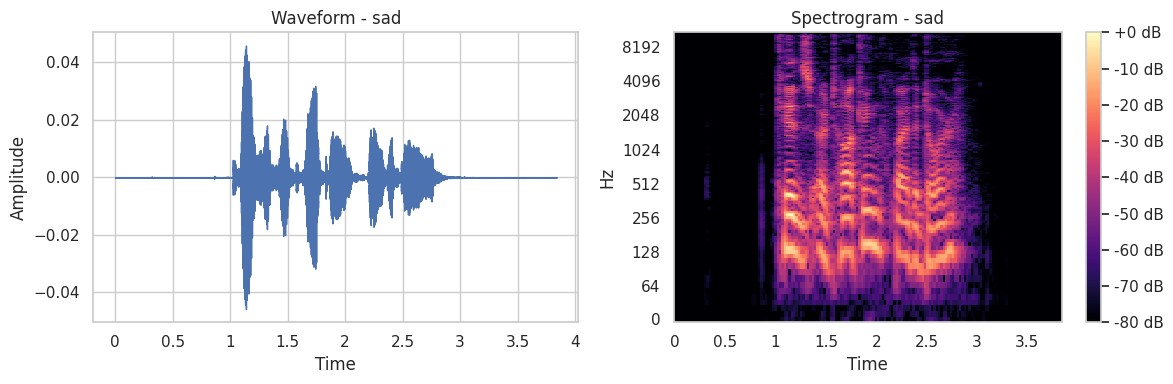

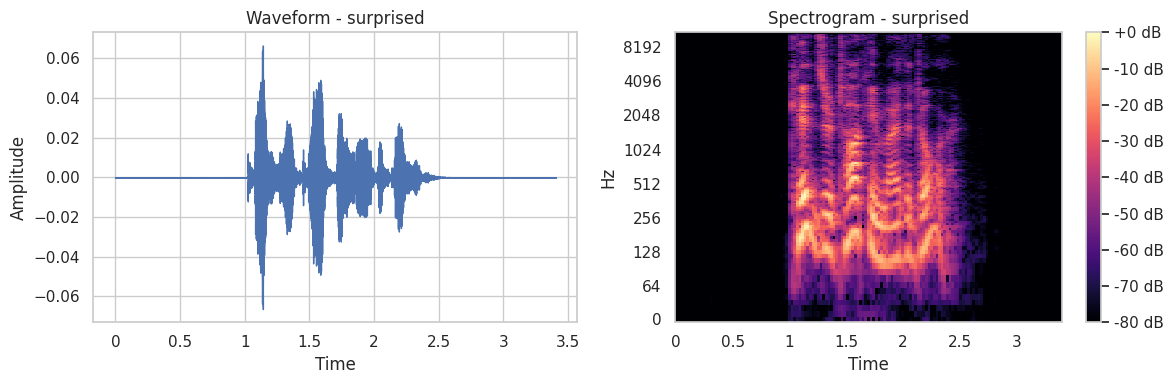

In [8]:
sample_df = df.groupby('emotion').first().reset_index()

for i, row in sample_df.iterrows():
    file_path = row['path']
    emotion = row['emotion']
    y, sr = librosa.load(file_path)

    plt.figure(figsize=(12, 4))
    
    # Waveform
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform - {emotion}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")

    # Spectrogram
    plt.subplot(1, 2, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.title(f"Spectrogram - {emotion}")
    plt.colorbar(format='%+2.0f dB')

    plt.tight_layout()
    plt.show()

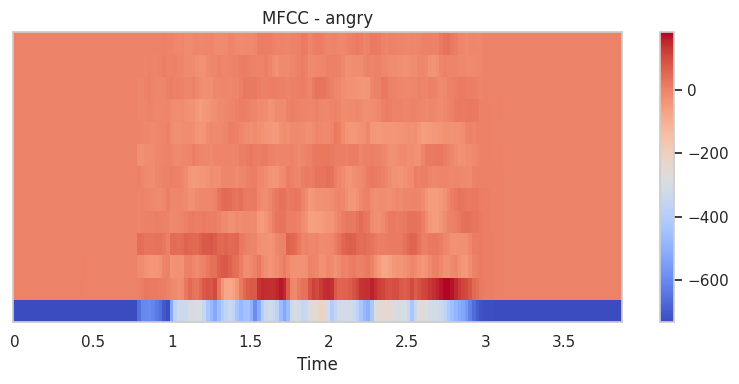

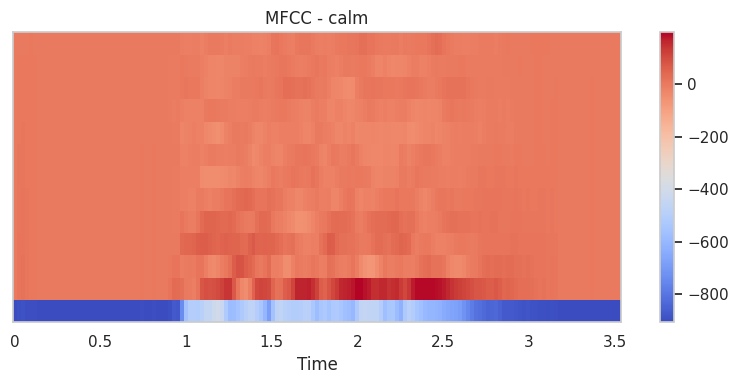

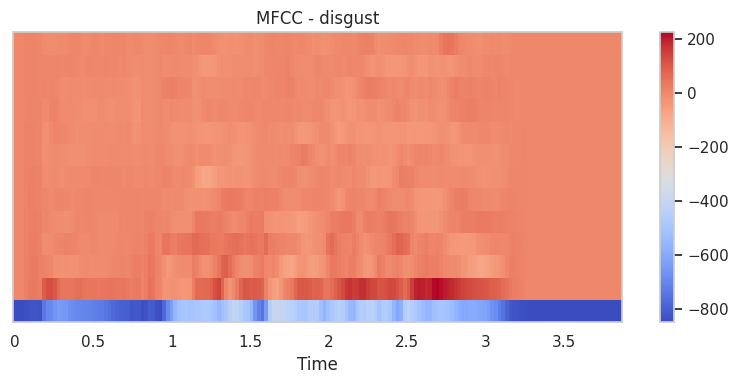

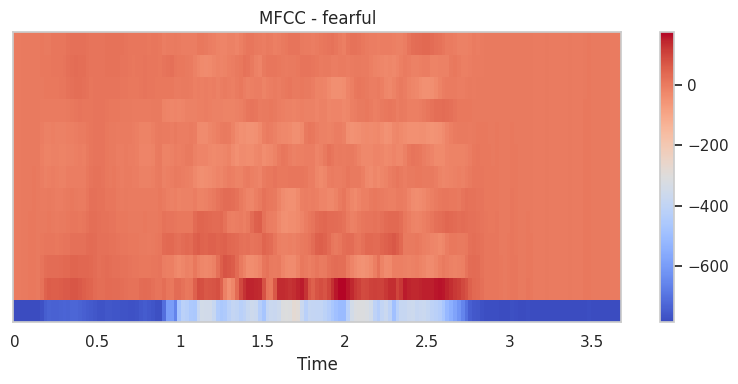

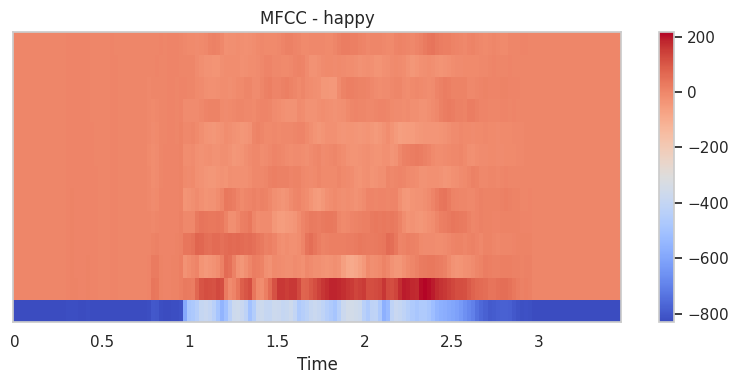

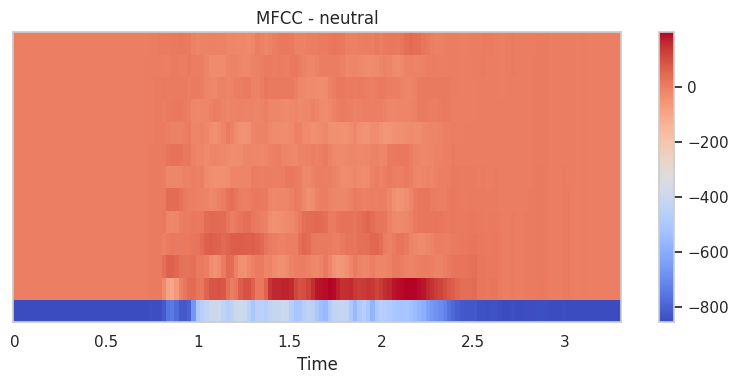

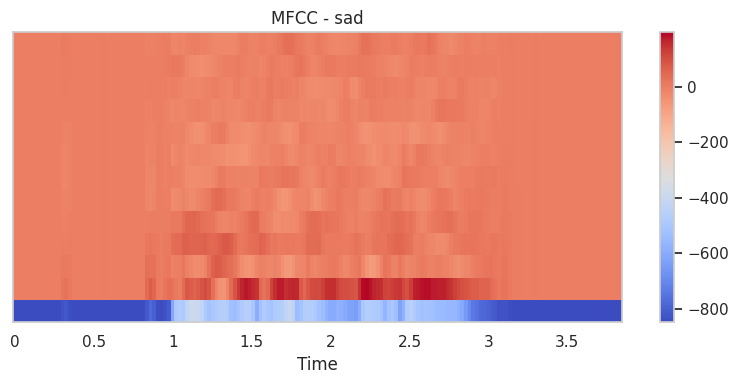

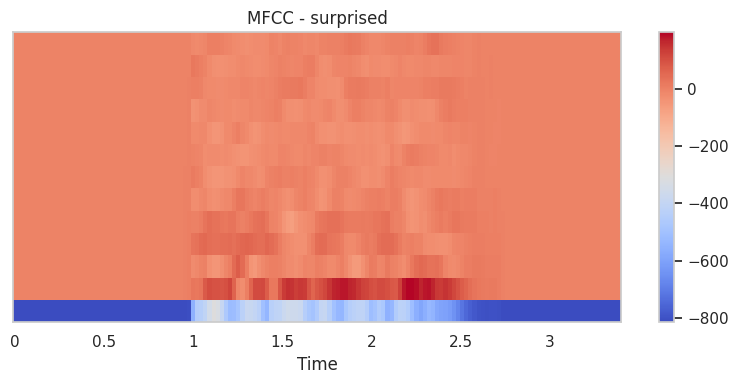

In [12]:
for i, row in sample_df.iterrows():
    file_path = row['path']
    emotion = row['emotion']
    y, sr = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    plt.figure(figsize=(8, 4))
    librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title(f'MFCC - {emotion}')
    plt.tight_layout()
    plt.show()


##  Preprocessing Recommended
- Convert audio to MFCCs(Mel Frequency Cepstral Coefficients) or Mel-spectrograms
- Normalize, trim silence, and pad to fixed length

---

In [9]:
# Step 1: First pass — trim silence and collect trimmed audios
def trim_and_normalize(path, sr=22050):
    try:
        y, _ = librosa.load(path, sr=sr)
        y_trimmed, _ = librosa.effects.trim(y, top_db=30)
        y_trimmed = librosa.util.normalize(y_trimmed)
        if np.mean(np.abs(y_trimmed)) < 0.005:
            return None
        return y_trimmed
    except:
        return None

tqdm.pandas()
df['trimmed_audio'] = df['path'].progress_apply(trim_and_normalize)
df = df[df['trimmed_audio'].notnull()].reset_index(drop=True)

100%|██████████| 2880/2880 [00:14<00:00, 197.30it/s]


In [10]:
# Compute duration of each trimmed audio (before padding/cropping)
df['trimmed_audio_duration'] = df['trimmed_audio'].apply(lambda y: len(y) / sr)

In [11]:
df.head()

,path,emotion,duration,trimmed_audio,trimmed_audio_duration
0,/teamspace/studios/this_studio/ai-internship-p...,neutral,3.303311,"[-0.000100123376, -0.000553536, -0.00020570285...",1.323537
1,/teamspace/studios/this_studio/ai-internship-p...,neutral,3.336689,"[-0.00054013735, 0.00029763806, 0.00042567565,...",1.346757
2,/teamspace/studios/this_studio/ai-internship-p...,neutral,3.269932,"[2.2755588e-05, 0.0005417399, 0.00018008103, -...",1.323537
3,/teamspace/studios/this_studio/ai-internship-p...,neutral,3.169841,"[0.0012256918, 0.0013623588, 0.0004901373, 0.0...",1.253878
4,/teamspace/studios/this_studio/ai-internship-p...,calm,3.536871,"[-0.00033286546, 0.0006757035, 0.0014872104, 0...",1.602177


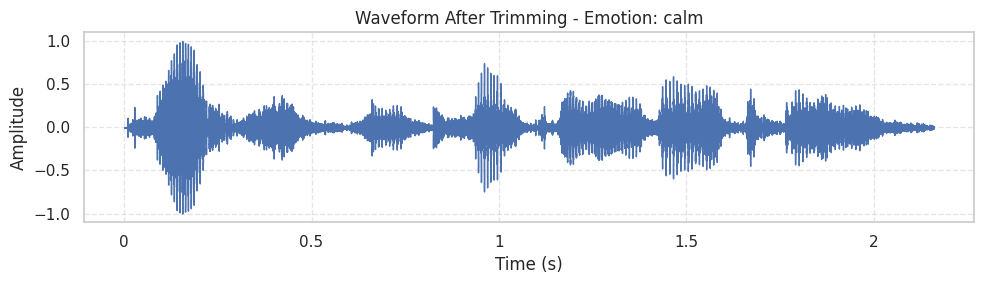

In [16]:
sample_index = 9
y = df.loc[sample_index, 'trimmed_audio']
emotion = df.loc[sample_index, 'emotion']
sr = 22050  

# Plot waveform
plt.figure(figsize=(10, 3))
librosa.display.waveshow(y, sr=sr)
plt.title(f"Waveform After Trimming - Emotion: {emotion}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


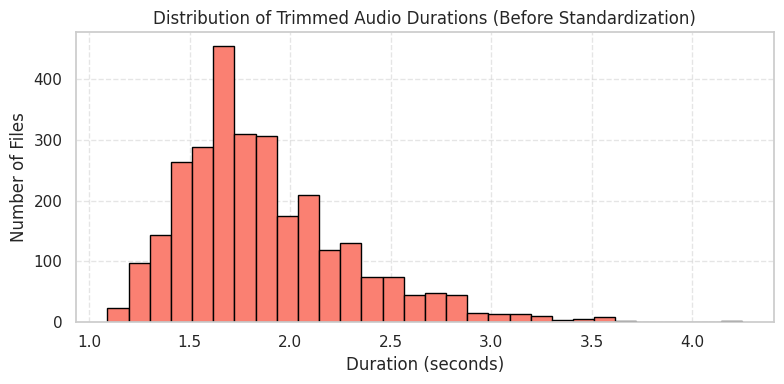

In [12]:


# Plot histogram of natural speech durations
plt.figure(figsize=(8, 4))
plt.hist(df['trimmed_audio_duration'], bins=30, color='salmon', edgecolor='black')
plt.title("Distribution of Trimmed Audio Durations (Before Standardization)")
plt.xlabel("Duration (seconds)")
plt.ylabel("Number of Files")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [13]:
# Step 2: Compute average duration of trimmed audio
avg_len = int(np.mean([len(y) for y in df['trimmed_audio']]))
avg_duration_sec = avg_len / 22050
print(f" Average trimmed duration: {avg_duration_sec:.2f} seconds")

 Average trimmed duration: 1.87 seconds


##  Step: Extract Features from Trimmed Audio

Let’s extract popular audio features using **Librosa**:

### 🎯 Common Features to Extract:
- **MFCCs** (Mel-Frequency Cepstral Coefficients)
- **Chroma Features**
- **Spectral Centroid**
- **Zero-Crossing Rate**
- **Root Mean Square Energy (RMSE)**


In [14]:
def extract_features(y, sr=22050, n_mfcc=13):
    try:
        features = {}
        
        # MFCCs
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        for i in range(n_mfcc):
            features[f'mfcc_{i+1}_mean'] = np.mean(mfccs[i])
            features[f'mfcc_{i+1}_std'] = np.std(mfccs[i])
        
        # Chroma
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        features['chroma_mean'] = np.mean(chroma)
        features['chroma_std'] = np.std(chroma)
        
        # Spectral Centroid
        centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        features['centroid_mean'] = np.mean(centroid)
        features['centroid_std'] = np.std(centroid)
        
        # Zero-Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(y)
        features['zcr_mean'] = np.mean(zcr)
        features['zcr_std'] = np.std(zcr)
        
        # RMS Energy
        rms = librosa.feature.rms(y=y)
        features['rms_mean'] = np.mean(rms)
        features['rms_std'] = np.std(rms)
        
        return features
    except:
        return None


In [15]:
# Extract features from trimmed_audio column with tqdm
features_list = []
for y in tqdm(df['trimmed_audio'], desc="Extracting features"):
    features = extract_features(np.array(y))
    features_list.append(features)

# Convert to DataFrame
features_df = pd.DataFrame(features_list)

# Merge with original dataframe
df_features = pd.concat([df.reset_index(drop=True), features_df], axis=1)

Extracting features: 100%|██████████| 2880/2880 [02:05<00:00, 22.99it/s]


In [20]:
df_features.shape

(2880, 39)

In [21]:
df_features.drop(columns=["path", "duration", "trimmed_audio", "trimmed_audio_duration"], inplace=True)


In [22]:
df_features.head()

,emotion,mfcc_1_mean,mfcc_1_std,mfcc_2_mean,mfcc_2_std,mfcc_3_mean,mfcc_3_std,mfcc_4_mean,mfcc_4_std,mfcc_5_mean,...,mfcc_13_mean,mfcc_13_std,chroma_mean,chroma_std,centroid_mean,centroid_std,zcr_mean,zcr_std,rms_mean,rms_std
0,neutral,-171.56549,72.104630,125.547390,56.976147,-9.674953,20.900707,24.648426,27.998905,14.435010,...,1.988304,14.843025,0.404057,0.299718,1776.288968,1070.954161,0.085197,0.065714,0.134482,0.072297
1,neutral,-182.68504,71.567726,116.302704,56.875687,-7.825341,21.139810,29.099022,22.788502,13.977194,...,-0.439447,14.006521,0.371468,0.305019,1833.889331,1084.637793,0.079027,0.058278,0.123995,0.068272
2,neutral,-195.30112,78.469790,124.038826,67.250435,-6.438734,31.049335,27.357557,23.979212,6.484827,...,3.142922,15.224808,0.373439,0.299316,1812.752557,1270.627729,0.094003,0.095240,0.115830,0.068650
3,neutral,-197.64673,81.783010,114.611880,65.476940,-0.160490,29.301233,28.123050,25.985706,9.483885,...,-1.364150,11.115534,0.397840,0.294477,1904.290876,1330.751604,0.098757,0.103640,0.104864,0.066566
4,calm,-178.94182,67.689316,115.149660,63.861430,-0.266135,29.604448,27.281796,25.261251,11.806400,...,0.636092,11.270839,0.395258,0.312809,1922.993510,1341.321468,0.103906,0.100092,0.138056,0.094605


In [24]:
df_features=pd.read_csv("/teamspace/studios/this_studio/ai-internship-project/Datasets/RAVDESS/df_features.csv")

In [24]:
# Number of unique emotions
num_unique = df_features['emotion'].nunique()
print("Number of unique emotions:", num_unique)

# Frequency count of each emotion
counts = df_features['emotion'].value_counts()
print("Counts of each emotion:\n", counts)


Number of unique emotions: 8
Counts of each emotion:
 emotion
calm         384
happy        384
sad          384
angry        384
fearful      384
disgust      384
surprised    384
neutral      192
Name: count, dtype: int64


In [26]:
le = LabelEncoder()
df_features['emotion'] = le.fit_transform(df_features['emotion'])

In [27]:
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(label_mapping)


{'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}


In [28]:
df_features.head()

,emotion,mfcc_1_mean,mfcc_1_std,mfcc_2_mean,mfcc_2_std,mfcc_3_mean,mfcc_3_std,mfcc_4_mean,mfcc_4_std,mfcc_5_mean,...,mfcc_13_mean,mfcc_13_std,chroma_mean,chroma_std,centroid_mean,centroid_std,zcr_mean,zcr_std,rms_mean,rms_std
0,5,-171.56549,72.104630,125.547390,56.976147,-9.674953,20.900707,24.648426,27.998905,14.435010,...,1.988304,14.843025,0.404057,0.299718,1776.288968,1070.954161,0.085197,0.065714,0.134482,0.072297
1,5,-182.68504,71.567726,116.302704,56.875687,-7.825341,21.139810,29.099022,22.788502,13.977194,...,-0.439447,14.006521,0.371468,0.305019,1833.889331,1084.637793,0.079027,0.058278,0.123995,0.068272
2,5,-195.30112,78.469790,124.038826,67.250435,-6.438734,31.049335,27.357557,23.979212,6.484827,...,3.142922,15.224808,0.373439,0.299316,1812.752557,1270.627729,0.094003,0.095240,0.115830,0.068650
3,5,-197.64673,81.783010,114.611880,65.476940,-0.160490,29.301233,28.123050,25.985706,9.483885,...,-1.364150,11.115534,0.397840,0.294477,1904.290876,1330.751604,0.098757,0.103640,0.104864,0.066566
4,1,-178.94182,67.689316,115.149660,63.861430,-0.266135,29.604448,27.281796,25.261251,11.806400,...,0.636092,11.270839,0.395258,0.312809,1922.993510,1341.321468,0.103906,0.100092,0.138056,0.094605


In [29]:
X = df_features.drop(columns=['emotion'])  

y = df_features['emotion']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 2304
Testing samples: 576


In [29]:
models = {
    'RandomForest': {
        'model': Pipeline([
            ('model', RandomForestClassifier(random_state=42))
        ]),
        'params': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [None, 10],
            'model__min_samples_split': [2, 5]
        }
    },
    'GradientBoosting': {
        'model': Pipeline([
            ('model', GradientBoostingClassifier(random_state=42))
        ]),
        'params': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.1],
            'model__max_depth': [3, 5]
        }
    },
    'SVM': {
        'model': Pipeline([
            ('scaler', StandardScaler()),
            ('model', SVC(random_state=42))
        ]),
        'params': {
            'model__C': [0.1, 1, 10],
            'model__kernel': ['linear', 'rbf'],
            'model__gamma': ['scale', 'auto']
        }
    },
    'MLP': {
        'model': Pipeline([
            ('scaler', StandardScaler()),
            ('model', MLPClassifier(max_iter=500, random_state=42))
        ]),
        'params': {
            'model__hidden_layer_sizes': [(100,), (50, 50), (128, 64)],
            'model__activation': ['relu', 'tanh'],
            'model__solver': ['adam'],
            'model__alpha': [0.0001, 0.001],
        }
    }
}

In [30]:
# Stratified K-Fold CV setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store best models
best_models = {}

# Use tqdm for model iteration progress
for name, m in tqdm(models.items(), desc="🔍 Model Training & Tuning Progress", ncols=100):
    cprint(f"\n🔧 Training and tuning {name}...", 'cyan', attrs=['bold'])
    
    grid = GridSearchCV(
        estimator=m['model'],
        param_grid=m['params'],
        cv=cv,
        scoring='accuracy',  # Or 'f1_macro'
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_train, y_train)
    
    cprint(f"\n✅ Best params for {name}: {grid.best_params_}", 'green')
    print(f"📈 Best CV accuracy: {grid.best_score_:.4f}")
    
    best_models[name] = grid.best_estimator_
    
    y_pred = grid.predict(X_test)
    
    cprint(f"\n📊 Validation Report for {name}:", 'magenta', attrs=['bold'])
    print(classification_report(y_test, y_pred, digits=4))
    print("🧩" + "="*70 + "\n")


🔍 Model Training & Tuning Progress:   0%|                                    | 0/4 [00:00<?, ?it/s]


🔧 Training and tuning RandomForest...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


🔍 Model Training & Tuning Progress:  25%|███████                     | 1/4 [00:15<00:47, 15.83s/it]


✅ Best params for RandomForest: {'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 100}
📈 Best CV accuracy: 0.8681

📊 Validation Report for RandomForest:
              precision    recall  f1-score   support

           0     0.9500    1.0000    0.9744        76
           1     0.9036    0.9740    0.9375        77
           2     1.0000    0.8961    0.9452        77
           3     0.8987    0.9221    0.9103        77
           4     0.9259    0.9740    0.9494        77
           5     1.0000    1.0000    1.0000        38
           6     0.9710    0.8701    0.9178        77
           7     0.9481    0.9481    0.9481        77

    accuracy                         0.9444       576
   macro avg     0.9497    0.9481    0.9478       576
weighted avg     0.9463    0.9444    0.9442       576

🧩======================================================================


🔧 Training and tuning GradientBoosting...
Fitting 5 folds for each of 8 candidates, totall

🔍 Model Training & Tuning Progress:  50%|█████████████▌             | 2/4 [05:43<06:38, 199.05s/it]


✅ Best params for GradientBoosting: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}
📈 Best CV accuracy: 0.8572

📊 Validation Report for GradientBoosting:
              precision    recall  f1-score   support

           0     0.9024    0.9737    0.9367        76
           1     0.9241    0.9481    0.9359        77
           2     0.9718    0.8961    0.9324        77
           3     0.9420    0.8442    0.8904        77
           4     0.9036    0.9740    0.9375        77
           5     1.0000    1.0000    1.0000        38
           6     0.9155    0.8442    0.8784        77
           7     0.9277    1.0000    0.9625        77

    accuracy                         0.9306       576
   macro avg     0.9359    0.9350    0.9342       576
weighted avg     0.9316    0.9306    0.9298       576

🧩======================================================================


🔧 Training and tuning SVM...
Fitting 5 folds for each of 12 candidates, totalling 60 fi

🔍 Model Training & Tuning Progress:  75%|████████████████████▎      | 3/4 [05:53<01:52, 112.89s/it]


✅ Best params for SVM: {'model__C': 10, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
📈 Best CV accuracy: 0.9067

📊 Validation Report for SVM:
              precision    recall  f1-score   support

           0     0.9744    1.0000    0.9870        76
           1     0.9872    1.0000    0.9935        77
           2     0.9740    0.9740    0.9740        77
           3     0.9494    0.9740    0.9615        77
           4     0.9259    0.9740    0.9494        77
           5     0.9487    0.9737    0.9610        38
           6     1.0000    0.8961    0.9452        77
           7     0.9733    0.9481    0.9605        77

    accuracy                         0.9670       576
   macro avg     0.9666    0.9675    0.9665       576
weighted avg     0.9678    0.9670    0.9669       576

🧩======================================================================


🔧 Training and tuning MLP...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converge


✅ Best params for MLP: {'model__activation': 'relu', 'model__alpha': 0.0001, 'model__hidden_layer_sizes': (128, 64), 'model__solver': 'adam'}
📈 Best CV accuracy: 0.8941

📊 Validation Report for MLP:
              precision    recall  f1-score   support

           0     0.9250    0.9737    0.9487        76
           1     1.0000    1.0000    1.0000        77
           2     0.9452    0.8961    0.9200        77
           3     0.9481    0.9481    0.9481        77
           4     0.9740    0.9740    0.9740        77
           5     0.9048    1.0000    0.9500        38
           6     0.9718    0.8961    0.9324        77
           7     0.9241    0.9481    0.9359        77

    accuracy                         0.9514       576
   macro avg     0.9491    0.9545    0.9511       576
weighted avg     0.9522    0.9514    0.9512       576

🧩======================================================================



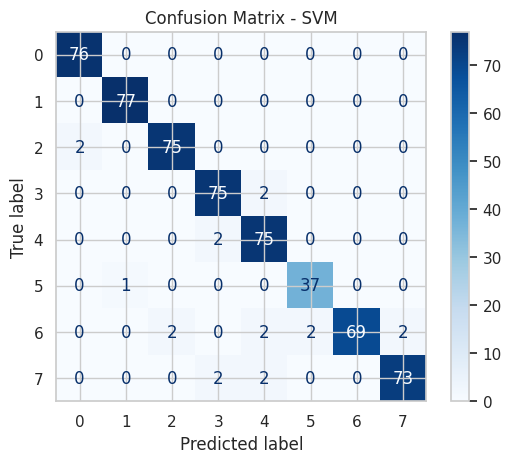

In [31]:
# --- SVM Confusion Matrix ---
svm_model = best_models['SVM']
y_pred_svm = svm_model.predict(X_test)

cm_svm = confusion_matrix(y_test, y_pred_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm)
disp_svm.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - SVM")
plt.show()

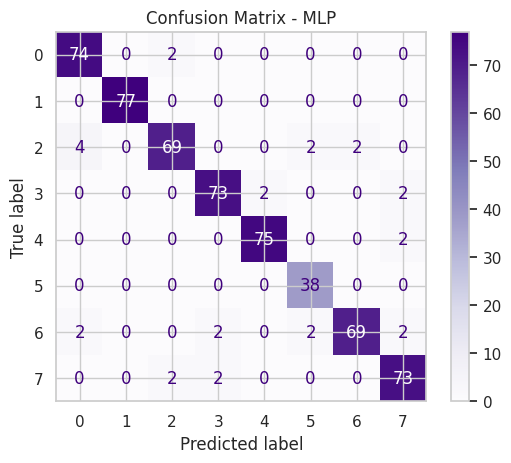

In [32]:
# --- MLP Confusion Matrix ---
mlp_model = best_models['MLP']
y_pred_mlp = mlp_model.predict(X_test)

cm_mlp = confusion_matrix(y_test, y_pred_mlp)
disp_mlp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp)
disp_mlp.plot(cmap='Purples', values_format='d')
plt.title("Confusion Matrix - MLP")
plt.show()


In [1]:
print('hedi')

hedi
